In [1]:
from fenics import *
import numpy as np

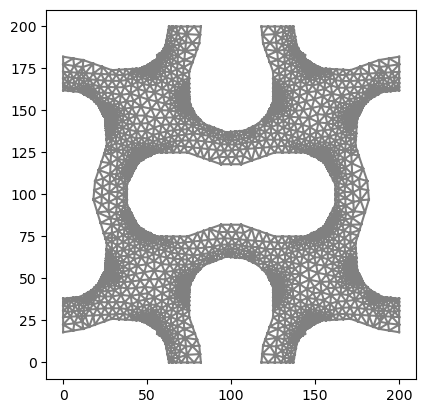

In [2]:
import os;
import matplotlib.pyplot as plt
path = './'
mesh = Mesh(path + 'test.xml');
plot(mesh)
materials = MeshFunction('size_t', mesh, mesh.topology().dim(), mesh.domains())

In [3]:
class ElasticityParameter(UserExpression):
    def __init__(self, materials, E1, E2, nu, beta1, beta2, parameter_type, **kwargs):
        super().__init__(**kwargs)
        self.materials = materials
        self.E1 = E1
        self.E2 = E2
        self.nu = nu
        self.beta1 = beta1
        self.beta2 = beta2
        self.parameter_type = parameter_type


    def eval_cell(self, values, x, cell):
        material_type = self.materials[cell.index]
        if self.parameter_type == 'beta':
            values[0] = self.beta1 if material_type == 1 else self.beta2
        elif self.parameter_type == 'mu':
            E = self.E1 if material_type == 1 else self.E2
            values[0] = E / (2 * (1 + self.nu))
        elif self.parameter_type == 'lambda':
            E = self.E1 if material_type == 1 else self.E2
            values[0] = E * self.nu / ((1 + self.nu) * (1 - 2 * self.nu))
    def value_shape(self):
        return ()

In [4]:
V = VectorFunctionSpace(mesh, 'P', 1)


# Elasticity parameters
E1, E2, nu = 10e9, 20e9, 0.3  # example values
beta1,beta2 = 10.,1
mu = ElasticityParameter(materials, E1, E2, nu, beta1, beta2, 'mu', degree=0)
lambda_ = ElasticityParameter(materials, E1, E2, nu, beta1, beta2, 'lambda', degree=0)
beta = ElasticityParameter(materials, E1, E2, nu, beta1, beta2, 'beta', degree=0)


In [5]:
delta_T = 1
def epsilon(u):
    return sym(grad(u))
def sigma(u,delta_T):
    # return lambda_ * tr(epsilon(u)) * Identity(len(u)) + 2 * mu * epsilon(u) - beta * (3*lmbda_+2*mu)*delta_T)*Identity(2)
    return (lambda_*tr(epsilon(u))- beta*(3*lambda_+2*mu)*delta_T)*Identity(2) + 2.0*mu*epsilon(u)
    

In [6]:
def left_boundary(x, on_boundary):
    return near(x[0], 0.0) and on_boundary
bc = DirichletBC(V, Constant((0., 0.)), left_boundary)

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Define variational problem
a = inner(sigma(u,delta_T), epsilon(v)) * dx
# L = Constant((0, 0)) * v * dx  # Assuming no body forces
L = inner(Constant((0, 0)), v) * dx

# Compute solution
u = Function(V, name="Displacement")

solve(lhs(a) == rhs(a) + L, u, bc)


Solving linear variational problem.


Object cannot be plotted directly, projecting to piecewise linears.


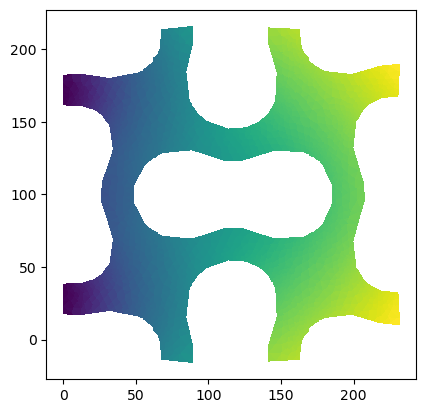

In [17]:
# Plot solution
plot(0.09*u, mode="displacement")
plot(mesh, alpha=0.5)